# Task 1: Build a Surrogate Model using RNN


In [ ]:
# !pip install livelossplot

In [ ]:
# Common imports
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from tqdm import tqdm
from livelossplot import PlotLosses


%matplotlib inline

### Data

In [ ]:
# Download data if needed
import zipfile

!curl "https://drive.usercontent.google.com/download?id={11eLWXq8ocg8snrHCLzlFf6hQg7j0V7Qy}&confirm=xxx" -o "Ferguson_fire_train.zip"

!curl "https://drive.usercontent.google.com/download?id={1z8iDZ4X11v0PYb5QBLbnWiz7L-3gryqD}&confirm=xxx" -o "Ferguson_fire_test.zip"

import zipfile
with zipfile.ZipFile("./Ferguson_fire_train.zip", 'r') as z:
    z.extractall('./')
with zipfile.ZipFile("./Ferguson_fire_test.zip", 'r') as z:
    z.extractall('./')
print('Data Download Done.')

In [2]:
train_data_path = "./Ferguson_fire_train.npy"
test_data_path = "./Ferguson_fire_test.npy"

# load the training data and reshape
train_data = np.load(train_data_path)
print(f"Train data shape: {np.shape(train_data)}")

# load the test data and reshape
test_data = np.load(test_data_path)
print(f"Test data shape: {np.shape(test_data)}")

Train data shape: (12500, 256, 256)
Test data shape: (5000, 256, 256)


In [3]:
# Reshape data to include channel dimension
train_data_series = train_data.reshape(125, 100, 1, 256, 256).astype(np.float32)
test_data_series = test_data.reshape(50, 100, 1, 256, 256).astype(np.float32)

# Verify the new shape
print(train_data_series.shape)  # Should be (100, 100, 1, 256, 256)
print(test_data_series.shape)   # Should be (50, 100, 1, 256, 256)

(125, 100, 1, 256, 256)
(50, 100, 1, 256, 256)


In [4]:
class WildfireDataset(Dataset):
    def __init__(self, data, window_size, step_size):
        """
        Args:
            data (numpy.ndarray): Input dataset with shape (num_sequences, seq_length, 1, height, width).
            window_size (int): Length of the window for each input sequence.
            step_size (int): Step size for sliding the window.
        """
        self.data = data
        self.window_size = window_size
        self.step_size = step_size
        self.sequences = []
        self.labels = []

        self._prepare_sequences()

    def _prepare_sequences(self):
        """
        Prepare sequences and labels based on the window size and step size.
        """
        num_sequences, seq_length, channels, height, width = self.data.shape
        interval = 10  # The interval for creating sub-sequences

        for seq_idx in range(num_sequences):
            for offset in range(interval):
                indices = np.arange(offset, seq_length, interval)
                if len(indices) < self.window_size:
                    continue

                for start_idx in range(0, len(indices) - self.window_size + 1, self.step_size): # Remember to +1 to confirm the last start_idx can be taken
                    end_idx = start_idx + self.window_size
                    if end_idx > len(indices):
                        break

                    x = self.data[seq_idx, indices[start_idx:end_idx-1]]
                    y = self.data[seq_idx, indices[end_idx-1]]
                    self.sequences.append(x)
                    self.labels.append(y)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        x = self.sequences[idx]
        y = self.labels[idx]
        return x, y

# # Example usage
# data = np.random.rand(125, 100, 1, 256, 256)  # Example data
# window_size = 5
# step_size = 5
# dataset = WildfireDataset(data, window_size, step_size)

# # Access the first element
# x, y = dataset[0]
# print(x.shape, y.shape)

### Model

In [8]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(
            in_channels=self.input_dim + self.hidden_dim,
            out_channels=4 * self.hidden_dim,
            kernel_size=self.kernel_size,
            padding=self.padding,
            bias=self.bias
        )

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError("Inconsistent list length.")

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        if hidden_state is None:
            hidden_state = self._init_hidden(batch_size=b, image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

class ConvLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, output_dim):
        super(ConvLSTMModel, self).__init__()
        self.convlstm = ConvLSTM(input_dim, hidden_dim, kernel_size, num_layers, batch_first=True, return_all_layers=False)
        self.conv = nn.Conv2d(hidden_dim[-1], output_dim, kernel_size=1, padding=0)

    def forward(self, x):
        lstm_out, _ = self.convlstm(x)
        output = self.conv(lstm_out[0][:, -1, :, :, :])
        return output

# Example: Create and print ConvLSTMModel
input_dim = 1  # Single channel (e.g., grayscale images)
hidden_dim = [64, 64]
kernel_size = (3, 3)
num_layers = 2
output_dim = 1  # Single channel output

model = ConvLSTMModel(input_dim, hidden_dim, kernel_size, num_layers, output_dim)
print(model)

ConvLSTMModel(
  (convlstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(65, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ConvLSTMCell(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (conv): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
)


In [5]:
class CNNLSTMModel(nn.Module):
    def __init__(self, input_channels, hidden_dim, output_channels, kernel_size=3, num_layers=1):
        super(CNNLSTMModel, self).__init__()
        
        # CNN to extract spatial features
        self.cnn = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces height and width by a factor of 2
            nn.Conv2d(64, 128, kernel_size=kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)   # Further reduces height and width by a factor of 2
        )
        
        # Calculate the size after the convolutions
        self.conv_output_size = 128 * (256 // 4) * (256 // 4)  # 128 channels, height and width reduced by a factor of 4
        
        # LSTM to handle the time dimension
        self.lstm = nn.LSTM(self.conv_output_size, hidden_dim, num_layers, batch_first=True)
        
        # Linear layer to map LSTM output to the required shape
        self.fc = nn.Linear(hidden_dim, self.conv_output_size)
        
        # Upsample and final conv layer to restore image size
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, output_channels, kernel_size=kernel_size, padding=kernel_size//2)
        )

    def forward(self, x):
        # Extract features for each frame
        b, t, c, h, w = x.size()
        cnn_features = []
        for i in range(t):
            features = self.cnn(x[:, i, :, :, :])  # (b, 128, h/4, w/4)
            cnn_features.append(features)
        cnn_features = torch.stack(cnn_features, dim=1)  # (b, t, 128, h/4, w/4)
        
        # Flatten spatial dimensions
        b, t, c, h, w = cnn_features.size()
        cnn_features_flat = cnn_features.view(b, t, -1)  # (b, t, 128*h/4*w/4)
        
        # Process with LSTM
        lstm_out, _ = self.lstm(cnn_features_flat)
        
        # The hidden_dim should match the last LSTM layer output dimension
        hidden_dim = lstm_out.size(-1)
        
        # Use the last output of LSTM and pass it through the linear layer
        lstm_out_last = lstm_out[:, -1, :]  # (b, hidden_dim)

        lstm_out_flat = self.fc(lstm_out_last)  # (b, 128*h/4*w/4)
        
        # Reshape LSTM output to (b, 128, h/4, w/4)
        lstm_out_reshaped = lstm_out_flat.view(b, 128, h, w)  # Use last LSTM output
        
        # Upsample to original image size and apply final conv layer
        output = self.upsample(lstm_out_reshaped)
        
        return output

# Example usage
input_channels = 1
hidden_dim = 256
output_channels = 1
kernel_size = 3
num_layers = 1

model = CNNLSTMModel(input_channels, hidden_dim, output_channels, kernel_size, num_layers)

# Dummy input with shape (batch_size, time_steps, channels, height, width)
x = torch.randn(8, 10, 1, 256, 256)
output = model(x)
print(output.shape)  # Should be (8, 1, 256, 256)


torch.Size([8, 1, 256, 256])


In [10]:
class LinearLSTMModel(nn.Module):
    def __init__(self, input_channels, img_size, hidden_dim, num_layers):
        super(LinearLSTMModel, self).__init__()
        self.input_channels = input_channels
        self.img_size = img_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Calculate the flattened image size
        self.flattened_size = input_channels * img_size * img_size
        
        # Linear layer to reduce dimensionality before LSTM
        self.linear1 = nn.Linear(self.flattened_size, hidden_dim)
        
        # LSTM
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        
        # Linear layer to transform LSTM output back to flattened image dimensions
        self.linear2 = nn.Linear(hidden_dim, self.flattened_size)
        
        # Unflatten the tensor back to image dimensions
        self.unflatten = nn.Unflatten(1, (input_channels, img_size, img_size))

    def forward(self, x):
        b, t, c, h, w = x.size()  # Get batch size, time steps, channels, height, width

        # Flatten the images and pass through the first linear layer
        x_flat = x.view(b * t, -1)  # Shape: (b * t, c * h * w)
        x_linear1 = self.linear1(x_flat)  # Shape: (b * t, hidden_dim)
        
        # Reshape to (b, t, hidden_dim)
        x_linear1 = x_linear1.view(b, t, -1)
        
        # LSTM layer
        lstm_out, _ = self.lstm(x_linear1)
        
        # Use the last output of the LSTM for each sequence
        lstm_out_last = lstm_out[:, -1, :]  # Shape: (b, hidden_dim)
        
        # Pass through the second linear layer and reshape to original image dimensions
        x_linear2 = self.linear2(lstm_out_last)  # Shape: (b, c * h * w)
        output = self.unflatten(x_linear2)  # Shape: (b, c, h, w)
        
        return output

# Example usage
input_channels = 1
img_size = 256  # Image height and width
hidden_dim = 512  # Number of LSTM hidden units
num_layers = 2  # Number of LSTM layers

model = LinearLSTMModel(input_channels, img_size, hidden_dim, num_layers).cuda()

# Example input
batch_size = 8
time_steps = 10
x = torch.randn(batch_size, time_steps, input_channels, img_size, img_size).cuda()
output = model(x)
print(output.shape)  # Should be (batch_size, input_channels, img_size, img_size)


torch.Size([8, 1, 256, 256])


### Training

In [11]:
window_size = 5
step_size = 5
batch_size = 32

train_dataset = WildfireDataset(train_data_series, window_size, step_size)
test_dataset = WildfireDataset(test_data_series, window_size, step_size)

# Use random_split to divide the dataset
total_size = len(train_dataset)
val_size = int(0.2 * total_size)  # 20% as validation set
train_size = total_size - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Print the sizes of the split datasets
print(f'Training dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Training dataset size: 2000
Validation dataset size: 500
Test dataset size: 1000


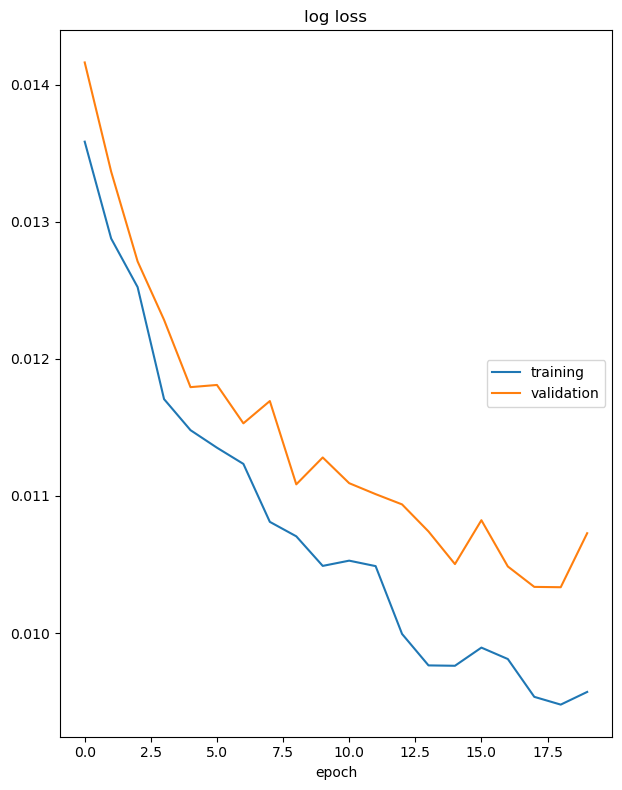

log loss
	training         	 (min:    0.009, max:    0.014, cur:    0.010)
	validation       	 (min:    0.010, max:    0.014, cur:    0.011)
Training complete


In [26]:
# Hyperparameters
learning_rate = 0.005
num_epochs = 20

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize livelossplot
liveplot = PlotLosses()

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    # Initialize tqdm progress bar
    tqdm_train_loader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for x_batch, y_batch in tqdm_train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x_batch.size(0)

        # Update tqdm progress bar with current loss
        tqdm_train_loader.set_postfix({'train_loss': train_loss / ((tqdm_train_loader.n + 1) * x_batch.size(0))})

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0

    # Initialize tqdm progress bar for validation
    tqdm_val_loader = tqdm(val_loader, desc=f"Validation", leave=False)

    with torch.no_grad():
        for x_batch, y_batch in tqdm_val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * x_batch.size(0)

            # Update tqdm progress bar with current loss
            tqdm_val_loader.set_postfix({'val_loss': val_loss / ((tqdm_val_loader.n + 1) * x_batch.size(0))})

    val_loss /= len(val_loader.dataset)

    # Update livelossplot with current loss
    liveplot.update({'log loss': train_loss, 'val_log loss': val_loss})
    liveplot.draw()

print("Training complete")


### Testing

In [27]:
# Initialize tqdm progress bar for testing
tqdm_test_loader = tqdm(test_loader, desc=f"Testing", leave=False)

test_loss = 0.0

# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    for x_batch, y_batch in tqdm_test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)

        test_loss += loss.item() * x_batch.size(0)

        # Update tqdm progress bar with current loss
        tqdm_test_loader.set_postfix({'test_loss': test_loss / ((tqdm_test_loader.n + 1) * x_batch.size(0))})

test_loss /= len(test_loader.dataset)

print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0134


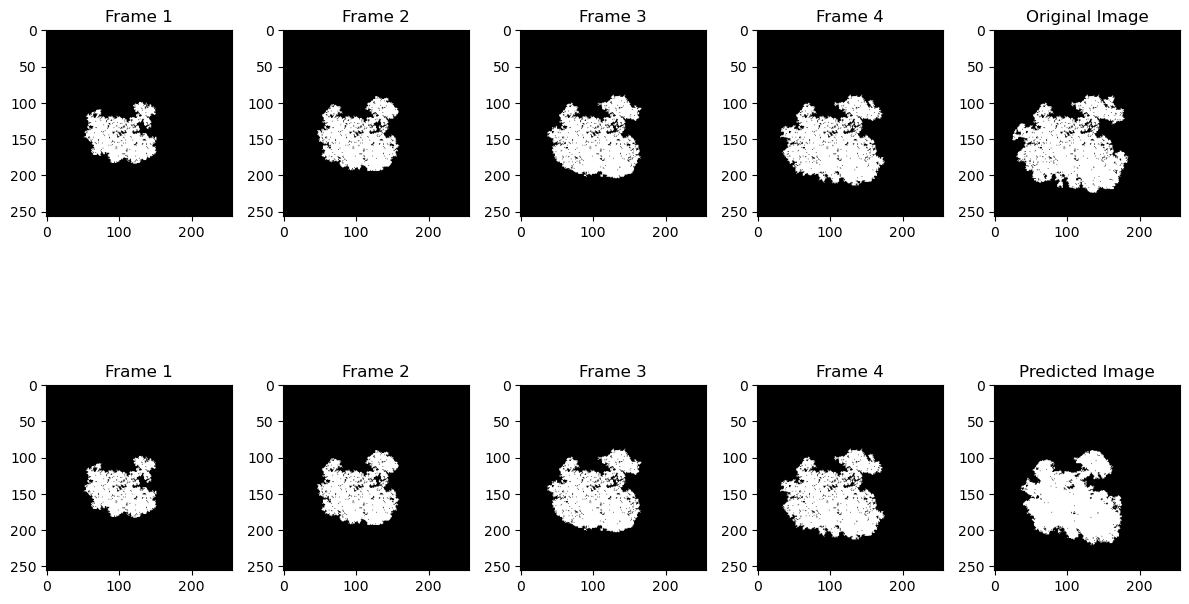

In [29]:
import random

# Set the model to evaluation mode
model.eval()

# Choose a random sample from the test dataset
random_idx = random.randint(0, len(test_dataset) - 1)
sample, target = test_dataset[random_idx]

# Move sample to device and add batch dimension
sample = torch.tensor(sample.astype(np.float32)).unsqueeze(0).to(device)

# Predict using the model
with torch.no_grad():
    output = model(sample)

# Convert output and target to numpy arrays
sample = sample.squeeze(2).cpu().numpy()
output = output.reshape(256,256).cpu().numpy()
output = (output >= 0.5).astype(np.float32)
target = target.reshape(256,256)


# Plot original sequence and predicted sequence
plt.figure(figsize=(12, 8))

# Plot original sequence
for i in range(sample.shape[1]):
    plt.subplot(2, sample.shape[1] + 1, i + 1)
    plt.imshow(sample[0, i], cmap='gray')
    plt.title(f'Frame {i + 1}')

# Plot original sequence again before the predicted sequence
for i in range(sample.shape[1]):
    plt.subplot(2, sample.shape[1] + 1, i + sample.shape[1] + 2)  # Start from the next column
    plt.imshow(sample[0, i], cmap='gray')
    plt.title(f'Frame {i + 1}')

# Plot target sequence
plt.subplot(2, sample.shape[1] + 1, sample.shape[1] + 1)
plt.imshow(target, cmap='gray')
plt.title('Original Image')

# Plot predicted sequence
plt.subplot(2, sample.shape[1] + 1, sample.shape[1]*2 + 2)  # Adjusted subplot position
plt.imshow(output, cmap='gray')
plt.title('Predicted Image')

plt.tight_layout()
plt.show()


### Prediction

In [15]:
!curl "https://drive.usercontent.google.com/download?id={1plQkOC8zbhnqHoupdxVioOoaM8FYnEHt}&confirm=xxx" -o "Ferguson_fire_background.npy"
!curl "https://drive.usercontent.google.com/download?id={1_u9KqsWjH45uozaWD6Ym3ZGYon88k6YI}&confirm=xxx" -o "Ferguson_fire_obs.npy"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
 18  640k   18  119k    0     0  81723      0  0:00:08  0:00:01  0:00:07 81802
100  640k  100  640k    0     0   417k      0  0:00:01  0:00:01 --:--:--  417k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:03 --:--:--     0
100 2560k  100 2560k    0     0   665k      0  0:0

In [16]:
data_path = "Ferguson_fire_"

# load the background data and reshape
background_data = np.load(data_path + "background.npy")
print(f"Background data shape: {np.shape(background_data)}")

# load the observation data and reshape
obs_data = np.load(data_path + "obs.npy")
print(f"observation data shape: {np.shape(obs_data)}")

Background data shape: (5, 256, 256)
observation data shape: (5, 256, 256)


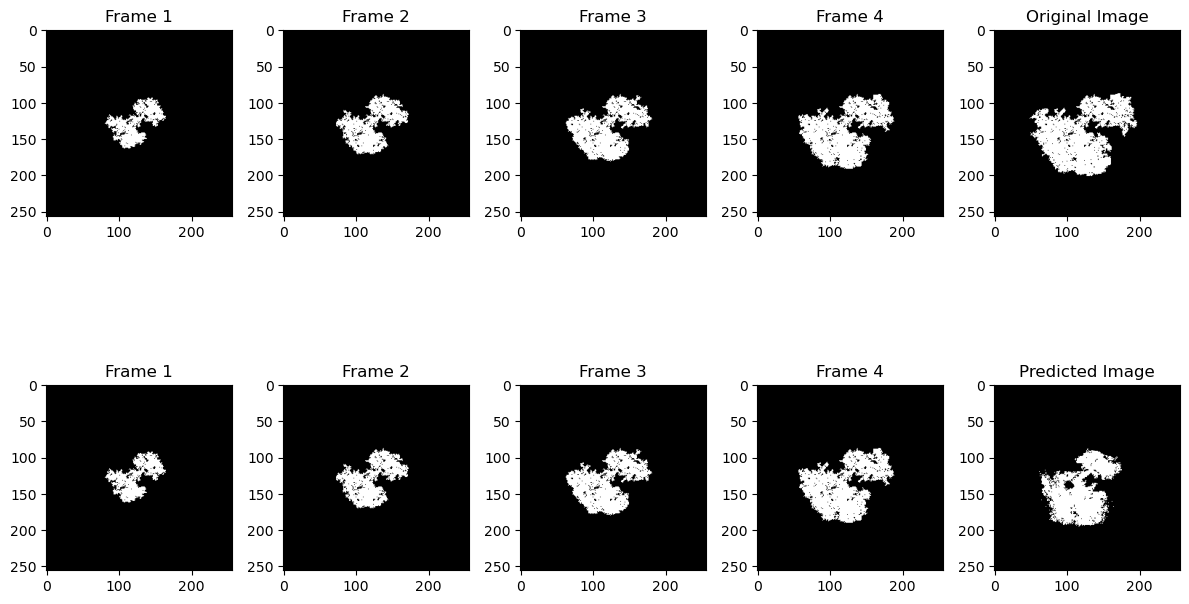

In [30]:
# Convert background_data to tensor and add batch and sequence dimensions
background_input = background_data[:4]
background_output = background_data[4]
background_input_tensor = torch.tensor(background_input.astype(np.float32)).unsqueeze(0).unsqueeze(2).to(device)

# Set the model to evaluation mode
model.eval()

# Predict the fifth image using the first four images
with torch.no_grad():
    predicted_output = model(background_input_tensor)

# Convert predicted output to numpy array
predicted_output = predicted_output.squeeze(0).squeeze(0).cpu().numpy()
predicted_output = (predicted_output >= 0.5).astype(np.float32)

# Plot original sequence and predicted sequence
plt.figure(figsize=(12, 8))

# Plot original sequence
for i in range(background_input.shape[0]):
    plt.subplot(2, background_input.shape[0] + 1, i + 1)
    plt.imshow(background_input[i], cmap='gray')
    plt.title(f'Frame {i + 1}')

for i in range(background_input.shape[0]):
    plt.subplot(2, background_input.shape[0] + 1, i + sample.shape[1] + 2)
    plt.imshow(background_input[i], cmap='gray')
    plt.title(f'Frame {i + 1}')

# Plot target sequence
plt.subplot(2, background_input.shape[0] + 1, background_input.shape[0] + 1)
plt.imshow(background_output, cmap='gray')
plt.title('Original Image')

# Plot predicted sequence
plt.subplot(2, background_input.shape[0] + 1, background_input.shape[0]*2 + 2)  # Adjusted subplot position
plt.imshow(predicted_output, cmap='gray')
plt.title('Predicted Image')

plt.tight_layout()
plt.show()

### Save

In [ ]:
# Save the model if needed
torch.save(model.state_dict(), 'trained_model.pth')